Mounted at /content/drive
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'autoformer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.1535 - mae: 0.3000 - mape: 161885.6875 - val_loss: 0.0393 - val_mae: 0.1472 - val_mape: 161718.3906
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - loss: 0.0325 - mae: 0.1342 - mape: 92494.1094 - val_loss: 0.0217 - val_mae: 0.1107 - val_mape: 107037.0938
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - loss: 0.0195 - mae: 0.1051 - mape: 67125.6406 - val_loss: 0.0164 - val_mae: 0.0968 - val_mape: 85669.8828
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 0.0151 - mae: 0.0933 - mape: 59299.9766 - val_loss: 0.0138 - val_mae: 0.0889 - val_mape: 69364.9688
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - loss: 0.0128 - mae: 0.0860 - mape: 52980.1680 - val_loss: 0.0121 - val_mae: 0.0831 - val_mape: 61717.2734
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - loss: 0.0113 - mae: 0.0806 - mape: 47971.3984 - val_loss: 0.0108 - val_mae: 0.0784 - val_mape: 57226.8086
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 10

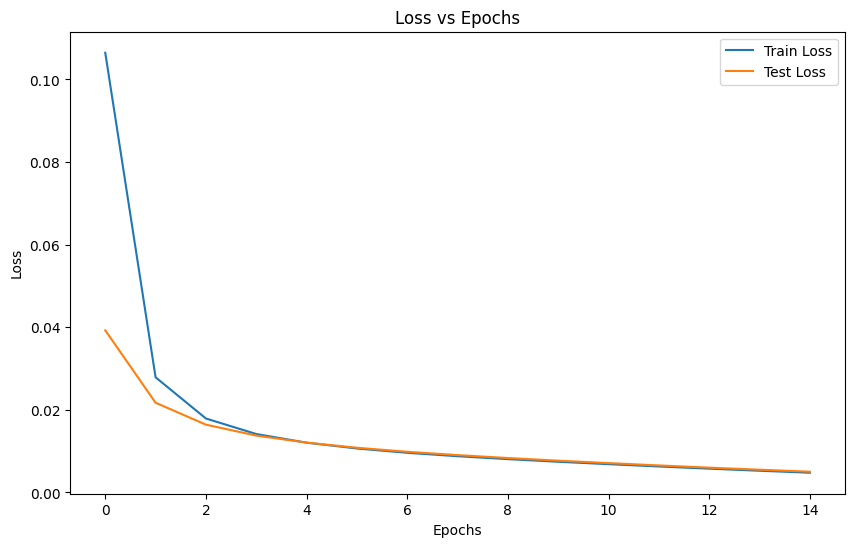

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


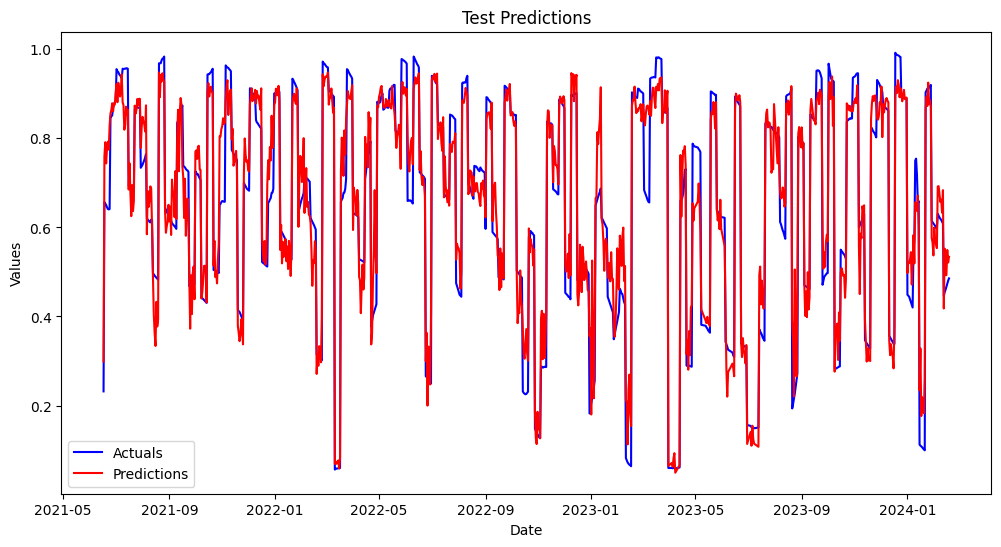

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


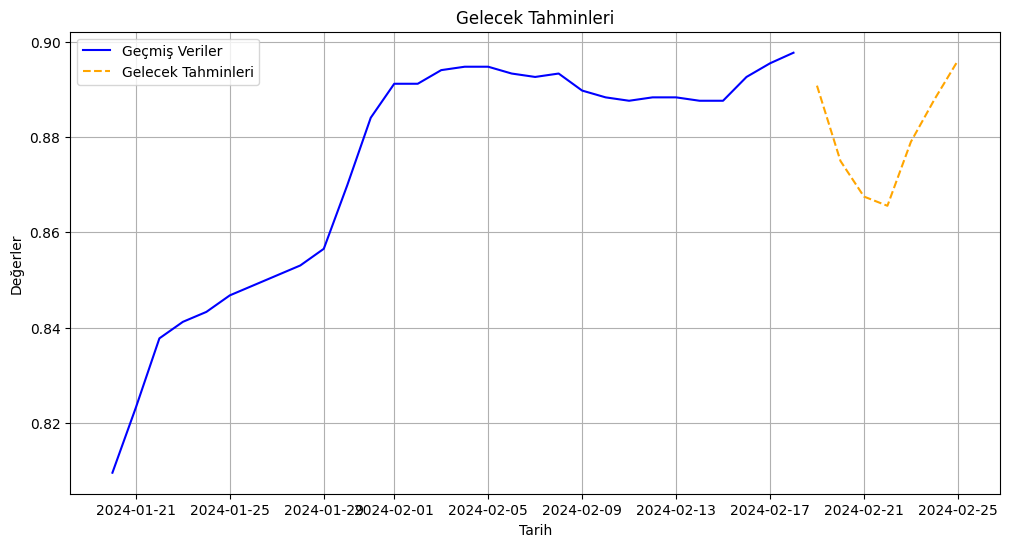

Gelecek Tahminleri:
2024-02-19: 0.89
2024-02-20: 0.87
2024-02-21: 0.87
2024-02-22: 0.87
2024-02-23: 0.88
2024-02-24: 0.89
2024-02-25: 0.90


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input,Layer, Dense, LayerNormalization, Dropout, Add, Conv1D, MultiHeadAttention
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from google.colab import drive
drive.mount('/content/drive')
import random
# Rastgelelik kontrolü
np.random.seed(42)
tf.random.set_seed(42)
# Veri Setini Yükleme
df = pd.read_json("/content/drive/MyDrive/Processed_Baraj_Data_Fixed_Deneme.json")

df['Tarih'] = pd.to_datetime(df['Tarih'])

df['Yil'] = df['Tarih'].dt.year
df['Ay'] = df['Tarih'].dt.month
df['Gun'] = df['Tarih'].dt.day

original_dates = df['Tarih']
df = df.drop(columns=['Tarih'])

df['mevsim'] = df['Ay'].apply(lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else (3 if x in [6, 7, 8] else 4)))
df['toplam_yağış'] = df[[col for col in df.columns if '_Yagis' in col]].sum(axis=1)
df['kümülatif_yağış_7gün'] = df['toplam_yağış'].rolling(window=7).sum()
df['yağış_lag_1'] = df['toplam_yağış'].shift(1)
df['yağış_lag_2'] = df['toplam_yağış'].shift(2)
df.fillna(0, inplace=True)

target_column = "Omerli_Doluluk"
input_features = df.drop(columns=[target_column]).values
target_values = df[target_column].values

# Normalize Etme
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(input_features)

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target_values.reshape(-1, 1))


# Veri Penceresi Oluşturma
input_window, output_window = 30, 7

def create_sequences(data, target, input_window, output_window):
    X, y = [], []
    for i in range(len(data) - input_window - output_window):
        X.append(data[i:i+input_window])
        y_seq = target[i+input_window:i+input_window+output_window].flatten()  # Çıktıyı doğrudan al
        y.append(y_seq)
    return np.array(X), np.array(y)


X, y = create_sequences(scaled_features, scaled_target, input_window, output_window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Autoformer Modeli

class SeriesDecomposition(Layer):
    def __init__(self, kernel_size=25):
        super(SeriesDecomposition, self).__init__()
        self.kernel_size = kernel_size
        self.avg_pool = tf.keras.layers.AveragePooling1D(pool_size=kernel_size, strides=1, padding='same')

    def call(self, x):
        trend = self.avg_pool(x)
        seasonal = x - trend
        return trend, seasonal

class AutoCorrelation(Layer):
    def __init__(self, d_model, dropout_rate=0.1):
        super(AutoCorrelation, self).__init__()
        self.d_model = d_model
        self.dense_q = Dense(d_model)
        self.dense_k = Dense(d_model)
        self.dense_v = Dense(d_model)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        q = self.dense_q(x)
        k = self.dense_k(x)
        v = self.dense_v(x)
        attention_scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(float(self.d_model))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_weights = self.dropout(attention_weights)
        return tf.matmul(attention_weights, v)

class AutoformerEncoder(Layer):
    def __init__(self, d_model, num_layers, dropout_rate=0.1):
        super(AutoformerEncoder, self).__init__()
        self.layers = [
            tf.keras.Sequential([
                AutoCorrelation(d_model, dropout_rate),
                LayerNormalization(),
                Dense(d_model, activation='relu'),
                Dropout(dropout_rate)
            ]) for _ in range(num_layers)
        ]

    def call(self, x):
        for layer in self.layers:
            x = x + layer(x)
        return x

class AutoformerDecoder(Layer):
    def __init__(self, d_model, num_layers, dropout_rate=0.1):
        super(AutoformerDecoder, self).__init__()
        self.layers = [
            tf.keras.Sequential([
                AutoCorrelation(d_model, dropout_rate),
                LayerNormalization(),
                Dense(d_model, activation='relu'),
                Dropout(dropout_rate)
            ]) for _ in range(num_layers)
        ]

    def call(self, x, encoder_output):
        for layer in self.layers:
            x = x + layer(x)
        return x + encoder_output

class Autoformer(tf.keras.Model):
    def __init__(self, input_len, output_len, d_model, num_layers):
        super(Autoformer, self).__init__()
        self.input_proj = Dense(d_model)  # Girişi d_model boyutuna çevirmek için
        self.decomposition = SeriesDecomposition()
        self.encoder = AutoformerEncoder(d_model, num_layers)
        self.decoder = AutoformerDecoder(d_model, num_layers)
        self.projection = Dense(output_len, activation="sigmoid")

    def call(self, x):
        x = self.input_proj(x)
        trend, seasonal = self.decomposition(x)
        encoded_trend = self.encoder(trend)
        encoded_seasonal = self.encoder(seasonal)
        decoded_trend = self.decoder(trend, encoded_trend)
        decoded_seasonal = self.decoder(seasonal, encoded_seasonal)
        output = self.projection(decoded_trend[:, -1, :] + decoded_seasonal[:, -1, :])

        return output


# Model oluşturma
input_len = X_train.shape[2]  # Giriş zaman serisi uzunluğu
output_len = y_train.shape[1]# Tahmin edilen zaman serisi uzunluğu
d_model = 64  # Modelin iç boyutu
num_layers = 2  # Encoder-Decoder katman sayısı

# Model oluşturma
model = Autoformer(input_len, output_len, d_model, num_layers)
model.build(input_shape=(None, input_len, X_train.shape[-1]))

# Modeli derleme
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="mse",
              metrics=["mae", "mape"])


start_time = time.time()
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))
train_time = time.time() - start_time

start_time = time.time()
predictions = model.predict(X_test)
inference_time = time.time() - start_time
actuals = y_test.flatten()
predictions = predictions.flatten()
print("\n=== Model Training and Inference Times ===")
print(f"Training Time   = {train_time:.2f} seconds")
print(f"Inference Time  = {inference_time:.2f} seconds")
actuals_real = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
predictions_real = scaler_target.inverse_transform(predictions.reshape(-1, 1)).flatten()



mse = mean_squared_error(actuals_real, predictions_real)
rmse = sqrt(mse)
mae = mean_absolute_error(actuals_real, predictions_real)
mape = mean_absolute_percentage_error(actuals_real, predictions_real)
r2 = r2_score(actuals_real, predictions_real)


print("\n=== Test Results ===")
print(f"MSE   = {mse:.4f}")
print(f"RMSE  = {rmse:.4f}")
print(f"MAE   = {mae:.4f}")
print(f"MAPE  = {mape:.4f}")
print(f"R²    = {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.show()

predictions = model.predict(X_test).flatten()
actuals = y_test.flatten()
relevant_dates = original_dates[-len(y_test):]

min_len = min(len(relevant_dates), len(actuals), len(predictions))
relevant_dates = relevant_dates[-min_len:]
actuals = actuals[-min_len:]
predictions = predictions[-min_len:]

plt.figure(figsize=(12, 6))
plt.plot(relevant_dates, actuals, label="Actuals", color="blue")
plt.plot(relevant_dates, predictions, label="Predictions", color="red")
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Test Predictions")
plt.legend()
plt.show()

future_steps = output_window  # Kaç gün ileri tahmin yapılacak
input_sequence = scaled_features[-input_window:].reshape(1, input_window, -1)  # Son giriş penceresi
future_predictions = []

for _ in range(future_steps):
    future_pred = model.predict(input_sequence)  # Model tahmini al
    predicted_value = future_pred.flatten()[0]  # Tek bir değer al

    future_predictions.append(predicted_value)  # Tahmini kaydet

    # Yeni tahmini giriş sekansına ekleyerek kaydırmalı pencere güncelle
    new_input = np.roll(input_sequence, shift=-1, axis=1)  # Kaydır
    new_input[0, -1, 0] = future_pred.flatten()[0]  # Yeni tahmini en sona ekle
    input_sequence = new_input  # Güncellenmiş giriş dizisini kullan

# Normalleştirilmiş tahminleri gerçek değerlere dönüştür
future_predictions_actual = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Tahmin edilen günler için tarih dizisi oluştur
future_dates = pd.date_range(original_dates.iloc[-1], periods=future_steps + 1, freq='D')[1:]

# Tahmin sonuçlarını görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(original_dates[-30:], scaler_target.inverse_transform(target_values[-30:].reshape(-1, 1)), label="Geçmiş Veriler", color="blue")
plt.plot(future_dates, future_predictions_actual, label="Gelecek Tahminleri", linestyle="--", color="orange")
plt.xlabel("Tarih")
plt.ylabel("Değerler")
plt.title("Gelecek Tahminleri")
plt.legend()
plt.grid()
plt.show()

# Tahmin edilen değerleri yazdır
print("Gelecek Tahminleri:")
for date, value in zip(future_dates, future_predictions_actual):
    print(f"{date.date()}: {value:.2f}")